In [3]:
import numpy as np
import pandas as pd
import customFunctions as fct
import foxes
import foxes.variables as FV
import foxes.input.farm_layout as layout
from foxes import algorithms
from foxes.output import FarmResultsEval
import matplotlib.pyplot as plt
import os
os.environ["FOXES_ENGINE"]    = "threads"
os.environ["FOXES_N_PROCS"]   = "1"

# 1) Load & prepare ERA5 from reanalysis.csv
era5 = pd.read_csv("reanalysis.csv", index_col=0, parse_dates=True)
era5.rename(columns={"WS100":"WS","WD100":"WD"}, inplace=True)
era5.replace(-999, np.nan, inplace=True)
era5 = era5.resample("h").mean()
era5.index = pd.to_datetime(era5.index)
era5 = era5.loc["2006-01-01":"2006-12-31"]

# 2) Ensure turbulence intensity column exists
if "TI" not in era5.columns:
    era5["TI"] = 0.10  
    
test_algo = fct.setup_algo(era5)


Turbine 0, T0: xy=(299005.80, 6070368.13), NREL5MW
Turbine 1, T1: xy=(298349.95, 6069364.01), NREL5MW
Turbine 2, T2: xy=(299546.60, 6069298.19), NREL5MW
Turbine 3, T3: xy=(300744.40, 6069255.93), NREL5MW
Turbine 4, T4: xy=(302075.57, 6068404.37), NREL5MW
Turbine 5, T5: xy=(298529.18, 6068179.05), NREL5MW
Turbine 6, T6: xy=(299725.82, 6068113.23), NREL5MW
Turbine 7, T7: xy=(300923.62, 6068070.97), NREL5MW
Turbine 8, T8: xy=(297371.96, 6067866.68), NREL5MW
Turbine 9, T9: xy=(303085.54, 6067758.28), NREL5MW
Turbine 10, T10: xy=(301715.50, 6067171.26), NREL5MW
Turbine 11, T11: xy=(304095.51, 6067112.19), NREL5MW
Turbine 12, T12: xy=(299341.24, 6066978.00), NREL5MW
Turbine 13, T13: xy=(298142.83, 6066947.93), NREL5MW
Turbine 14, T14: xy=(300539.04, 6066935.73), NREL5MW
Turbine 15, T15: xy=(302771.25, 6066601.55), NREL5MW
Turbine 16, T16: xy=(305105.47, 6066466.11), NREL5MW
Turbine 17, T17: xy=(301478.71, 6065995.11), NREL5MW
Turbine 18, T18: xy=(303781.22, 6065955.46), NREL5MW
Turbine 19, T

In [4]:
[turbine_stats, summary]= fct.compute_yield(test_algo)
print(summary)
#print(turbine_stats)

Selecting 'DefaultEngine(n_procs=12, chunk_size_states=None, chunk_size_points=None)'
DefaultEngine: Selecting engine 'process'
ProcessEngine: Calculating 8760 states for 133 turbines
ProcessEngine: Computing 12 chunks using 12 processes


100%|██████████| 12/12 [01:11<00:00,  5.97s/it]


Capacity added to farm results
Ambient capacity added to farm results
Efficiency added to farm results
{'farm_ambient_power_MW': np.float64(375.8549135178814), 'farm_net_power_MW': np.float64(357.49247011038244), 'farm_efficiency': np.float64(0.9511448626928076), 'annual_yield_GWh': np.float64(3131.6340381669497)}


### Actually the Algorithm (here: "test_algo") is the kind of Object having the Farm and the States within its scope. Here is an example how one can get the farm object or the layout back from the perviously created Algorithm object:

In [5]:
# retrieving the wind farm from the algorithm object and give out a property of this wind farm instance
print(test_algo.farm.name)

my_farm


DefaultEngine: Selecting engine 'single'
SingleChunkEngine: Calculating 8760 states for 1 turbines
SingleChunkEngine: Running single chunk calculation for 8760 states


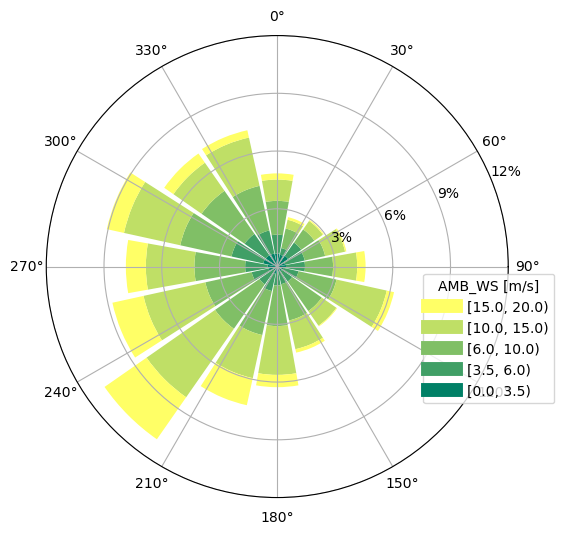

In [6]:
# retrieving the states from the algorithm object and generate a windrose from it
my_states = test_algo.states
o = foxes.output.StatesRosePlotOutput(my_states, point=[0.0, 0.0, 100.0])
o.get_figure(16, FV.AMB_WS, [0, 3.5, 6, 10, 15, 20], figsize=(6, 6))
plt.show()


# Redoing task 5 with the new functions

In [8]:
# see what options are already available among the build in models
mbook = foxes.models.ModelBook()
mbook.print_toc()
print("Available wake models:")
print(sorted(mbook.wake_models.keys()))

axial_induction
---------------
Betz: BetzAxialInduction()
Madsen: MadsenAxialInduction()

farm_controllers
----------------
basic_ctrl: BasicFarmController()

farm_models
-----------
farm_PMask: Turbine2FarmModel(PowerMask(var_ws_P=REWS3, P_lim=100, induction=Betz))
farm_hubh_data: Turbine2FarmModel(RotorCentreCalc())
farm_kTI: Turbine2FarmModel(kTI(kTI=None, kb=0, ti_var=TI, k_var=k))
farm_kTI_amb: Turbine2FarmModel(kTI(kTI=None, kb=0, ti_var=AMB_TI, k_var=k))
farm_thrust2ct: Turbine2FarmModel(Thrust2Ct(thrust_var=T, var_ws_ct=REWS2))
farm_yaw2yawm: Turbine2FarmModel(YAW2YAWM())
farm_yawm2yaw: Turbine2FarmModel(YAWM2YAW())

ground_models
-------------
ground_mirror: GroundMirror()
no_ground: NoGround()

blh_mirror_h<height>: WakeMirror with
  height=(Boundary layer wake reflection height)
Example: blh_mirror_h500

partial_wakes
-------------
centre: PartialCentre()
rotor_points: RotorPoints()
top_hat: PartialTopHat()

axiwake<n>: PartialAxiwake with
  n=(Number of evaluation points)


### 1) create a new wind turbine model from the power curve files

In [9]:
    # define data file path
costum_turbine_data = 'turbine-info/power_curves/IEA-15MW-D240-H150.csv'

# add a new model to the book
mbook.turbine_types['custom_turbine'] = foxes.models.turbine_types.PCtFile(costum_turbine_data,rho = 1.225)

# show model specs
mbook.turbine_types['custom_turbine']

PCtFile(D=240.0, H=150.0, P_nominal=15000.0, P_unit=kW, rho=1.225, var_ws_ct=REWS2, var_ws_P=REWS3)

### 2) use a different wake model

In [10]:
wake_models = ['Rathmann','VortexSheet']

## Initate new foxes algorithm

In [11]:
alternative_algo = fct.setup_algo(era5,'alternative_farm',wake_models=wake_models,model_book=mbook,turbine_key=['custom_turbine'])

Turbine 0, T0: xy=(299005.80, 6070368.13), custom_turbine
Turbine 1, T1: xy=(298349.95, 6069364.01), custom_turbine
Turbine 2, T2: xy=(299546.60, 6069298.19), custom_turbine
Turbine 3, T3: xy=(300744.40, 6069255.93), custom_turbine
Turbine 4, T4: xy=(302075.57, 6068404.37), custom_turbine
Turbine 5, T5: xy=(298529.18, 6068179.05), custom_turbine
Turbine 6, T6: xy=(299725.82, 6068113.23), custom_turbine
Turbine 7, T7: xy=(300923.62, 6068070.97), custom_turbine
Turbine 8, T8: xy=(297371.96, 6067866.68), custom_turbine
Turbine 9, T9: xy=(303085.54, 6067758.28), custom_turbine
Turbine 10, T10: xy=(301715.50, 6067171.26), custom_turbine
Turbine 11, T11: xy=(304095.51, 6067112.19), custom_turbine
Turbine 12, T12: xy=(299341.24, 6066978.00), custom_turbine
Turbine 13, T13: xy=(298142.83, 6066947.93), custom_turbine
Turbine 14, T14: xy=(300539.04, 6066935.73), custom_turbine
Turbine 15, T15: xy=(302771.25, 6066601.55), custom_turbine
Turbine 16, T16: xy=(305105.47, 6066466.11), custom_turbine


In [12]:
fct.compute_yield(alternative_algo)

DefaultEngine: Selecting engine 'process'
ProcessEngine: Calculating 8760 states for 133 turbines
ProcessEngine: Computing 12 chunks using 12 processes


100%|██████████| 12/12 [02:19<00:00, 11.61s/it]


Capacity added to farm results
Ambient capacity added to farm results
Efficiency added to farm results


(      Ambient Yield [GWh]  Net Yield     [GWh]  Efficiency         
 T0                79.9413            79.480331             0.994234
 T1                79.9413            79.269556             0.991597
 T2                79.9413            79.182476             0.990508
 T3                79.9413            79.315628             0.992173
 T4                79.9413            79.232955             0.991139
 ...                   ...                  ...                  ...
 T128              79.9413            79.102245             0.989504
 T129              79.9413            78.963606             0.987770
 T130              79.9413            79.131666             0.989872
 T131              79.9413            79.196201             0.990679
 T132              79.9413            79.245823             0.991300
 
 [133 rows x 3 columns],
 {'farm_ambient_power_MW': np.float64(1213.7206572863374),
  'farm_net_power_MW': np.float64(1198.8521267090189),
  'farm_efficiency': np.float64